# EM casing response dipole source

In [1]:
import numpy as np
import os
import scipy.sparse as sp
import pandas as pd
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
import pickle
from multiprocessing import Pool

# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg import(
    maps, Report, data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils
)
from pymatsolver import Pardiso

from utils import pad_for_casing_and_data

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [3]:
directory_path = "/t40array/lheagy/permeable-conductive-sphere"

In [4]:
def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

# Example usage
ensure_directory_exists(directory_path)

Directory '/t40array/lheagy/permeable-conductive-sphere' already exists.


In [5]:
save_figures = False
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [6]:
# # conductivities
sigma_air = 1e-4
sigma_back = np.r_[1e-1]
casing_l = 500
sigma_casing = 5e6
mur_casing = np.r_[1, 10, 25, 50, 100, 150, 200]

# # casing geometry
casing_b = 0.5  
casing_t = 0.2 #np.r_[5e-3, 7.5e-3, 10e-3, 12.5e-3, 15e-3, 20e-3]
casing_a = casing_b - casing_t

In [7]:
src_dz = 1
src_z = -2 #np.r_[-100, -250, -400, -495, -500, -550, -600]

In [8]:
# generate a mesh
hx = pad_for_casing_and_data(
   casing_outer_radius = casing_b,
    csx1 = casing_t/4, 
    csx2 = 25, 
    pfx1 = 1.3,
    pfx2 = 1.5, 
    domain_x = 100, 
    npadx = 10
)

hz = np.r_[np.flipud(hx), hx]
# pfz = 1.3
# npad_z = 28
# csz = 1
# n_core_extra = 10
# ncore_z = int(np.max(np.r_[np.abs(casing_l), np.abs(src_z)]) / csz) + n_core_extra
# hz = discretize.utils.unpack_widths(
#     [(csz, npad_z, -pfz), (csz, ncore_z), (csz, npad_z, pfz)]
# )

(-4867.36572265625, 4867.36572265625)

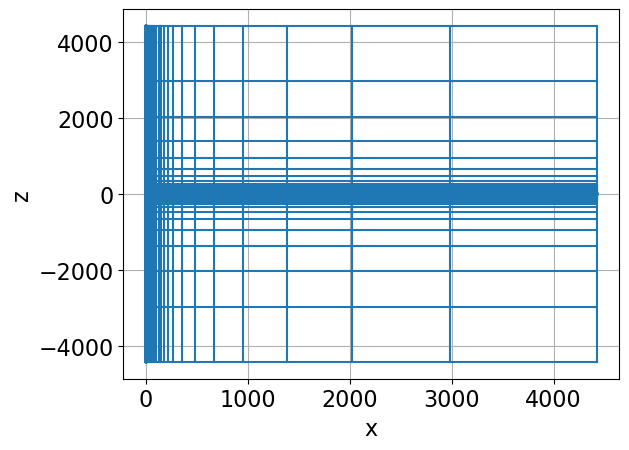

In [9]:
mesh = discretize.CylindricalMesh(
    [hx, np.r_[2*np.pi], hz], origin="00C",
)

lim = None #0.5*np.r_[-1, 1]
fig, ax = plt.subplots(1, 1)
mesh.plot_grid(ax=ax)
ax.set_xlim(lim)
ax.set_ylim(lim)
# ax.set_ylim(-50, 10)

In [10]:
mesh.n_cells

4802

In [11]:
def get_physical_property_model(mesh, casing_a, casing_b, casing_l, sigma_back, sigma_casing, sigma_air=1e-4, mur_casing=1):

    model = np.ones(mesh.n_cells) * sigma_back

    mur = np.ones(mesh.n_cells)

    inds_casing = (
        ((mesh.cell_centers[:, 0]**2 + mesh.cell_centers[:, 2]**2) > casing_a**2) &
        ((mesh.cell_centers[:, 0]**2 + mesh.cell_centers[:, 2]**2) < casing_b**2)
    )
        
    model[inds_casing] = sigma_casing
    mur[inds_casing] = mur_casing

    return model, mur

    

In [12]:
sigma_back

array([0.1])

In [13]:
models = {}
for mur in mur_casing:
    key = f"casing_sig{sigma_casing:1.0e}_mur{mur:1.0f}"
    sig_model, mur_model = get_physical_property_model(mesh, casing_a, casing_b, casing_l, sigma_back[0], sigma_casing, mur_casing=mur)
    models[key] = {
        "sigma": sig_model, 
        "mur": mur_model
    }
keys = list(models.keys())

In [14]:
keys

['casing_sig5e+06_mur1',
 'casing_sig5e+06_mur10',
 'casing_sig5e+06_mur25',
 'casing_sig5e+06_mur50',
 'casing_sig5e+06_mur100',
 'casing_sig5e+06_mur150',
 'casing_sig5e+06_mur200']

In [15]:
def plot_casing(model, xlim=None, zlim=None, vmin=None, vmax=None, ax=None, cb_label=None, logscale=True, show_cb=False): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1)
    if logscale is True: 
        pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax), "cmap":"Spectral_r"}
    else: 
        pcolor_opts={"norm":Normalize(vmin=vmin, vmax=vmax), "cmap":"Spectral_r"}
    out = mesh.plot_image(
        model, pcolor_opts=pcolor_opts, ax=ax, mirror=True
    )

    if show_cb is True: 
        cb = plt.colorbar(out[-1], shrink=0.5)
        cb.set_label(cb_label)

    if xlim is not None: 
        ax.set_xlim(xlim)
    if zlim is not None: 
        ax.set_ylim(zlim)

    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax, out

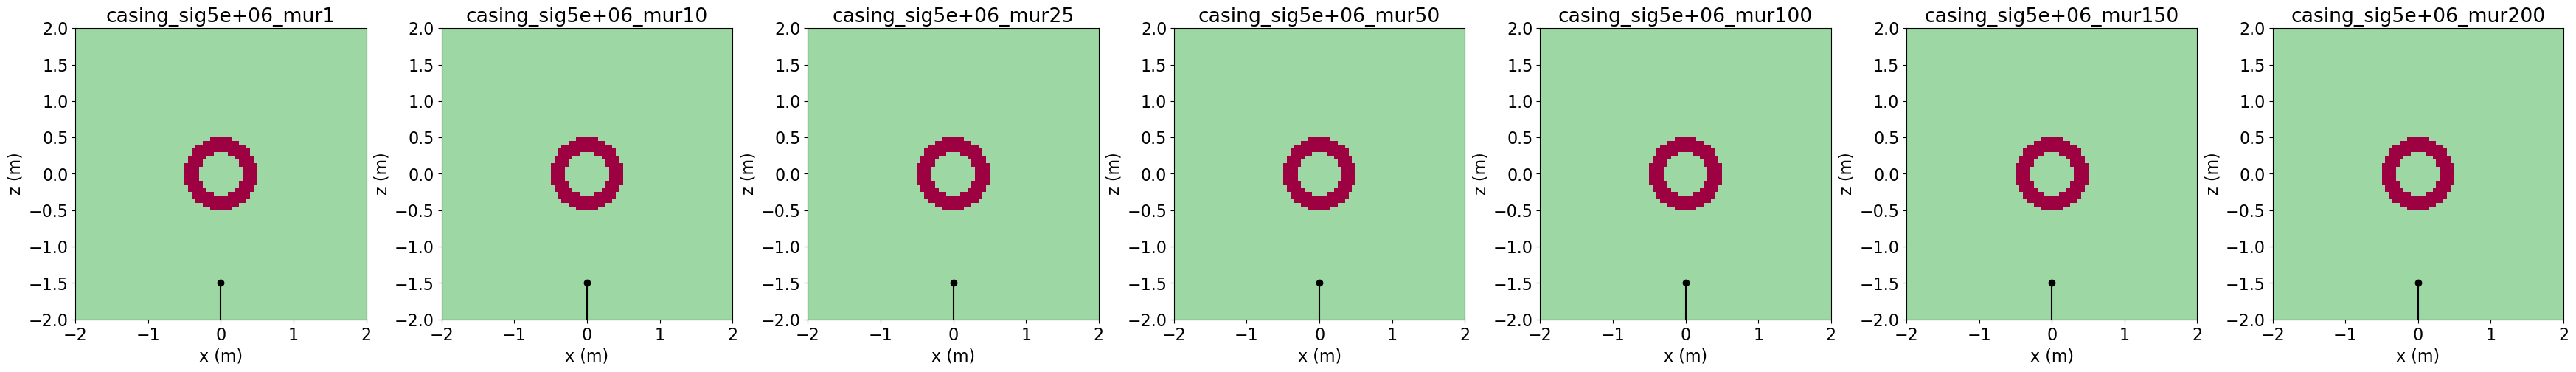

In [16]:
plot_keys = keys
fig, ax = plt.subplots(1, len(plot_keys), figsize=(5*len(plot_keys), 7))

xlim = 2*np.r_[-1, 1]
zlim = xlim
vmin = sigma_air
vmax = sigma_casing

for i, key in enumerate(plot_keys):
    plot_casing(models[key]["sigma"], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[i])
    ax[i].set_title(key)
    ax[i].plot(np.r_[0, 0], src_z + src_dz/2 * np.r_[-1, 1], "-ok")
    ax[i].set_aspect(1)

plt.tight_layout()
# for loc in src_z:
#     ax.plot(np.r_[0, 0], loc + src_dz/2*np.r_[-1, 1], "-k", lw=4, alpha=0.5)

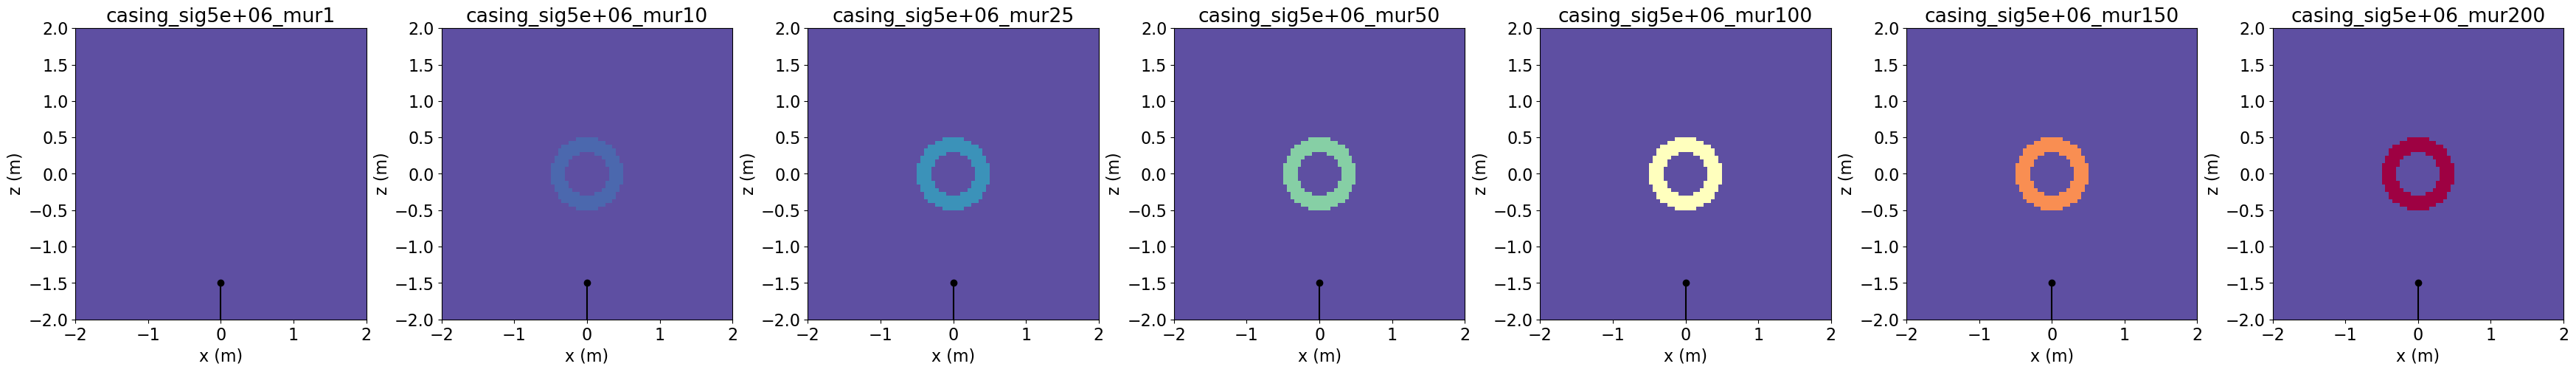

In [17]:
plot_keys = keys
fig, ax = plt.subplots(1, len(plot_keys), figsize=(5*len(plot_keys), 7))

xlim = 2*np.r_[-1, 1]
zlim = xlim
vmin = 1
vmax = mur_casing.max()

for i, key in enumerate(plot_keys):
    plot_casing(models[key]["mur"], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[i], logscale=False)
    ax[i].set_title(key)
    ax[i].plot(np.r_[0, 0], src_z + src_dz/2 * np.r_[-1, 1], "-ok")
    ax[i].set_aspect(1)

plt.tight_layout()
# for loc in src_z:
#     ax.plot(np.r_[0, 0], loc + src_dz/2*np.r_[-1, 1], "-k", lw=4, alpha=0.5)

## set up the simulations

In [18]:
frequencies = 10**np.linspace(-1, 4, 36)
frequencies

array([1.00000000e-01, 1.38949549e-01, 1.93069773e-01, 2.68269580e-01,
       3.72759372e-01, 5.17947468e-01, 7.19685673e-01, 1.00000000e+00,
       1.38949549e+00, 1.93069773e+00, 2.68269580e+00, 3.72759372e+00,
       5.17947468e+00, 7.19685673e+00, 1.00000000e+01, 1.38949549e+01,
       1.93069773e+01, 2.68269580e+01, 3.72759372e+01, 5.17947468e+01,
       7.19685673e+01, 1.00000000e+02, 1.38949549e+02, 1.93069773e+02,
       2.68269580e+02, 3.72759372e+02, 5.17947468e+02, 7.19685673e+02,
       1.00000000e+03, 1.38949549e+03, 1.93069773e+03, 2.68269580e+03,
       3.72759372e+03, 5.17947468e+03, 7.19685673e+03, 1.00000000e+04])

In [19]:
src_list = []
src_locations = np.array([
    [0, 0, src_z+src_dz/2.],
    [0, 0, src_z-src_dz/2.]
])
for f in frequencies: 
    src = fdem.sources.LineCurrent([], location=src_locations, frequency=f)
    src_list.append(src)

wires = maps.Wires(("sigma", mesh.n_cells), ("mur", mesh.n_cells))
permeability_map = maps.MuRelative(mesh)

survey = fdem.Survey(src_list)

sim = fdem.simulation.Simulation3DMagneticField(
    mesh=mesh, sigmaMap=wires.sigma, muMap=permeability_map * wires.mur,
    survey=survey, solver=Pardiso, #mu=mur * mu_0
#     verbose=True
)

In [20]:
def run_simulation(key):
    
    filename = os.path.sep.join([directory_path, key])

    t = time.time()
    print(f"starting {key}..., saving to {filename}")
    fields = sim.fields(np.r_[models[key]["sigma"], models[key]["mur"]])
    print(f" ... done. {time.time()-t:1.2e} \n")
    
    np.save(filename, fields[:, "hSolution"])

    return fields

In [21]:
fields = {}

In [22]:
for key in keys: 
    if key not in fields: 
        fields[key] = run_simulation(key)

starting casing_sig5e+06_mur1..., saving to /t40array/lheagy/permeable-conductive-sphere/casing_sig5e+06_mur1
 ... done. 1.04e+00 

starting casing_sig5e+06_mur10..., saving to /t40array/lheagy/permeable-conductive-sphere/casing_sig5e+06_mur10
 ... done. 5.62e-01 

starting casing_sig5e+06_mur25..., saving to /t40array/lheagy/permeable-conductive-sphere/casing_sig5e+06_mur25
 ... done. 5.37e-01 

starting casing_sig5e+06_mur50..., saving to /t40array/lheagy/permeable-conductive-sphere/casing_sig5e+06_mur50
 ... done. 5.34e-01 

starting casing_sig5e+06_mur100..., saving to /t40array/lheagy/permeable-conductive-sphere/casing_sig5e+06_mur100
 ... done. 5.21e-01 

starting casing_sig5e+06_mur150..., saving to /t40array/lheagy/permeable-conductive-sphere/casing_sig5e+06_mur150
 ... done. 5.13e-01 

starting casing_sig5e+06_mur200..., saving to /t40array/lheagy/permeable-conductive-sphere/casing_sig5e+06_mur200
 ... done. 5.30e-01 



In [23]:
fields

{'casing_sig5e+06_mur1': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f815b3e3c10>,
 'casing_sig5e+06_mur10': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f815b3fb8d0>,
 'casing_sig5e+06_mur25': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f815b376cd0>,
 'casing_sig5e+06_mur50': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f815bf12250>,
 'casing_sig5e+06_mur100': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f816402a5d0>,
 'casing_sig5e+06_mur150': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f815bc7a250>,
 'casing_sig5e+06_mur200': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7f815bc8d510>}

In [24]:
keys[4]

'casing_sig5e+06_mur100'

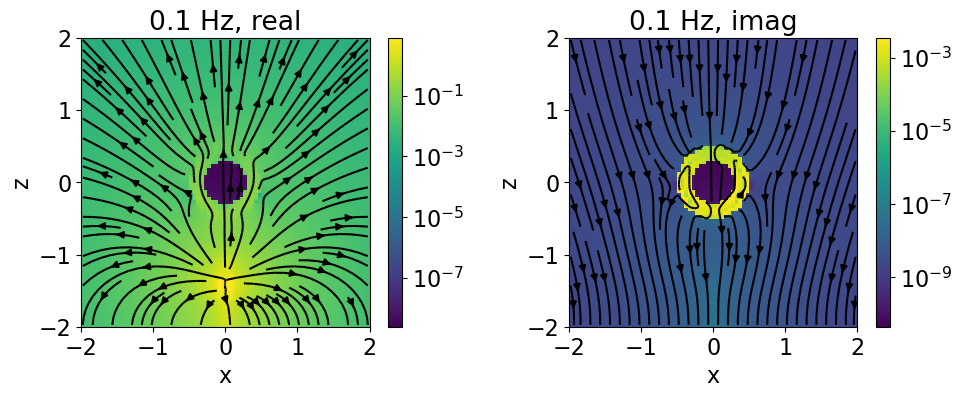

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

key = keys[0]
freq_ind = 0
xlim = 2*np.r_[-1, 1]
zlim = xlim

field_plot = (mesh.average_face_to_cell_vector * fields[key][fields[key].simulation.survey.source_list[freq_ind], "j"])

for i, component in enumerate(["real", "imag"]): 
    out = mesh.plot_image(
        getattr(field_plot, component), "CCv", view="vec", 
        range_x = xlim, range_y = zlim,
        # sample_grid = np.r_[10, 10],
        mirror=True, #mirror_data=field_mirror,
        ax=ax[i], 
        pcolor_opts={"norm":LogNorm()}
    )
    # ax[i].plot(rx_ex_re.locations[:, 0], rx_ex_re.locations[:, 2], "w.", ms=1)
    cb = plt.colorbar(out[0], ax=ax[i])
    # cb.set_label("Electric Field (V/m)")
    ax[i].set_aspect(1)
    ax[i].set_title(f"{frequencies[freq_ind]} Hz, {component}")
plt.tight_layout()

In [26]:
# def load_fields(name, conductivity, mur):
#     solution = np.load(f"{directory}/fields_{name}.npy")
#     sim = generate_simulation(mur)
#     sim.model = conductivity
#     f = sim.fieldsPair(sim)
#     f[:, sim._solutionType] = solution
#     return f

# choose models to focus on

In [27]:
len(frequencies)

36

In [28]:
# casing_t_inv = np.r_[5e-3]
# mur_inv = np.r_[1, 50, 100, 150, 200]
# freq_inds_inv = np.arange(0, 31, 1)
# src_ind_inv = 5

# inv_keys = []
# for t in casing_t_inv:
#     for mur in mur_inv:
#         inv_keys.append(f"casing_{mur}_{t:1.2e}")
# inv_keys

In [29]:
# frequencies[freq_inds_inv]

In [30]:
# fields = {}
# for key in inv_keys:
#     # if key not in fields.keys():
#     fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"])

In [31]:
rcParams["font.size"] = 12

In [32]:
fields.keys()

dict_keys(['casing_sig5e+06_mur1', 'casing_sig5e+06_mur10', 'casing_sig5e+06_mur25', 'casing_sig5e+06_mur50', 'casing_sig5e+06_mur100', 'casing_sig5e+06_mur150', 'casing_sig5e+06_mur200'])

In [33]:
def skin_depth(f, sigma, mur):
    return np.sqrt(2/(2*np.pi*f*sigma*mur*mu_0))

In [34]:
rx_x = np.linspace(1, 20, 19)
rx_z = -np.linspace(-15, 15, 21)
rx_z

array([ 15. ,  13.5,  12. ,  10.5,   9. ,   7.5,   6. ,   4.5,   3. ,
         1.5,  -0. ,  -1.5,  -3. ,  -4.5,  -6. ,  -7.5,  -9. , -10.5,
       -12. , -13.5, -15. ])

In [35]:
def create_receivers():
    rx_ex_re = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="real",
    )
    rx_ex_im = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="imag",
    )
    rx_ez_re = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="z",
        component="real",
    )
    rx_ez_im = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="z",
        component="imag",
    )
    return rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im

In [36]:
rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im = create_receivers()
Px = rx_ex_re.getP(mesh, "Fx")
Pz = rx_ez_re.getP(mesh, "Fz")

In [37]:
frequencies

array([1.00000000e-01, 1.38949549e-01, 1.93069773e-01, 2.68269580e-01,
       3.72759372e-01, 5.17947468e-01, 7.19685673e-01, 1.00000000e+00,
       1.38949549e+00, 1.93069773e+00, 2.68269580e+00, 3.72759372e+00,
       5.17947468e+00, 7.19685673e+00, 1.00000000e+01, 1.38949549e+01,
       1.93069773e+01, 2.68269580e+01, 3.72759372e+01, 5.17947468e+01,
       7.19685673e+01, 1.00000000e+02, 1.38949549e+02, 1.93069773e+02,
       2.68269580e+02, 3.72759372e+02, 5.17947468e+02, 7.19685673e+02,
       1.00000000e+03, 1.38949549e+03, 1.93069773e+03, 2.68269580e+03,
       3.72759372e+03, 5.17947468e+03, 7.19685673e+03, 1.00000000e+04])

In [38]:
range(len(frequencies))

range(0, 36)

In [39]:
# get data_vectors
dobs_dict = {}

for k in keys:
    tmp_dict = {}
    for si in range(len(frequencies)):
        src = sim.survey.source_list[si]
        e = fields[k][src, "e"]
        edatax = (Px * e).squeeze()
        edataz = (Pz * e).squeeze()
        tmp_dict[frequencies[si]] = {
            "real_x": edatax.real,
            "imag_x": edatax.imag,
            "real_z": edataz.real,
            "imag_z": edataz.imag
        }
    dobs_dict[k] = tmp_dict
        

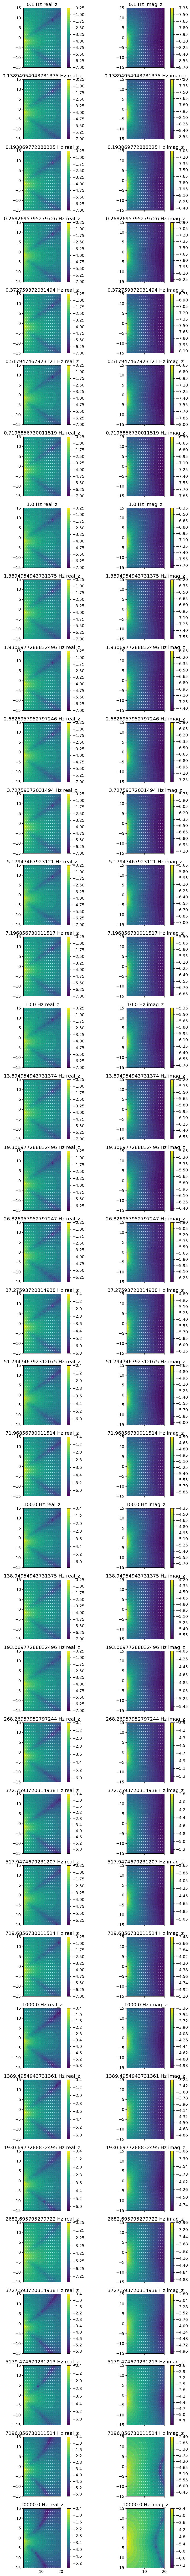

In [40]:
fig, ax = plt.subplots(len(frequencies), 2, figsize=(10, len(frequencies)*3), sharex=True)

key_ind = 0
key = keys[key_ind]

for i, freq in enumerate(frequencies): 
    # ax.plot(rx_x, dobs_dict[key][freq]["real"].reshape((len(rx_x), len(rx_z)), order="F"), "o" );
    for j, component in enumerate(["real_z", "imag_z"]): 
        plt.colorbar(
            ax[i, j].contourf(
                rx_x, rx_z, np.log10(np.abs(dobs_dict[key][freq][component].reshape((len(rx_x), len(rx_z)), order="F").T)), 30,
                # vmin=-7, vmax=-2
                # norm=LogNorm()
            ), ax=ax[i, j]
        )
        
        ax[i, j].plot(rx_ex_re.locations[:, 0], rx_ex_re.locations[:, 2], "w.", ms=1)
        ax[i, j].set_aspect(1)
        ax[i, j].set_title(f"{freq} Hz {component}")

plt.tight_layout()


In [41]:
def get_amplitude_phase(real, imag):
    # real = f.real
    # imag = f.imag
    amplitude = np.sqrt(real**2 + imag**2)
    phase = 180/np.pi*np.arctan2(imag, real)
    return amplitude, phase

In [42]:
# fig, ax = plt.subplots(len(frequencies), 2, figsize=(10, len(frequencies)*3), sharex=True)

# key_ind = 0
# key = keys[key_ind]

# for i, freq in enumerate(frequencies): 
#     amp, phase = get_amplitude_phase(*(dobs_dict[key][freq][component].reshape((len(rx_x), len(rx_z)), order="F").T for component in ["real", "imag"]))
#     for j, plotme in enumerate([np.log10(np.abs(amp)), phase]): 
#         plt.colorbar(
#             ax[i, j].contourf(
#                 rx_x, rx_z, plotme, 30,
#                 # vmin=-7, vmax=-2
#                 # norm=LogNorm()
#                 cmap = "twilight" if j == 1 else "viridis"
#             ), ax=ax[i, j]
#         )
        
#         ax[i, j].plot(rx_e_re.locations[:, 0], rx_e_re.locations[:, 2], "w.", ms=1)
#         ax[i, j].set_aspect(1)
#         ax[i, j].set_title(f"{freq} Hz {'amplitude' if j==0 else 'phase'}")

# plt.tight_layout()


# set up mappings and simulation

In [43]:
def create_maps(key, true_inds=False, casing_t_ind=0):
    inds_interior = (
        (mesh.cell_centers[:, 0]**2 + mesh.cell_centers[:, 2]**2) < casing_b**2
    )

    active_inds_sigma = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=np.log(models[key]["sigma"][~inds_interior])
    )

    active_inds_mur = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=models[key]["mur"][~inds_interior]
    )

    projection_sigma = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])
    projection_mu = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])

    exp_map = maps.ExpMap(mesh)
    mur_map = maps.MuRelative(mesh)

    sigma_map = exp_map * active_inds_sigma * projection_sigma
    mu_map = mur_map * active_inds_mur * projection_mu

    return sigma_map, mu_map

In [44]:
src_locations

array([[ 0. ,  0. , -1.5],
       [ 0. ,  0. , -2.5]])

In [45]:
def create_survey(freq, components=["x", "z"]): 
    rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im = create_receivers()
    rx_list = []
    if "x" in components: 
        rx_list.append([rx_ex_re, rx_ex_im])
    if "z" in components: 
        rx_list.append([rx_ez_re, rx_ez_im])
    src = fdem.sources.LineCurrent(list(np.hstack(rx_list)), location=src_locations, frequency=freq)
    return fdem.Survey([src])

In [46]:
# create the simulation
def create_simulation(key, survey, invert_mu=False, true_inds=False):
    sigma_map, mu_map = create_maps(key, true_inds)

    if invert_mu is True: 
        wires = maps.Wires(("sigma", 1), ("mu", 1))
        sim = fdem.simulation.Simulation3DMagneticField(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map * wires.sigma,
            muMap=mu_map * wires.mu 
        )
    else: 
        sim = fdem.simulation.Simulation3DMagneticField(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map
        )
    return sim


In [47]:
t = casing_t
sigdc = sigma_casing * (1-(casing_b-t)**2/casing_b**2)

data0 = {}
res0 = {}
rms0 = {}

components = ["x", "z"]

for i, key in enumerate(keys): 
    data_tmp = {}
    res_tmp = {}
    rms_tmp = {}
    
    for freq in frequencies: 
        survey = create_survey(freq, components)
    
        receivers = []
        if "x" in components: 
            receivers.append(["real_x", "imag_x"])
        if "z" in components: 
            receivers.append(["real_z", "imag_z"])
        dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    
        sim = create_simulation(key, survey, invert_mu=False)
        dpred = sim.dpred(np.log(sigdc))

        data_tmp[freq] = dpred
        res_tmp[freq] = dpred - dobsvec
        rms_tmp[freq] = np.sqrt(np.sum(res_tmp[freq]**2) / len(res_tmp[freq]))
    data0[key] = data_tmp
    res0[key] = res_tmp
    rms0[key] = rms_tmp

In [48]:
from string import ascii_lowercase

In [49]:
sigdc

3200000.0

In [50]:
plot_inds = [2, 3, 4, 5, 6]

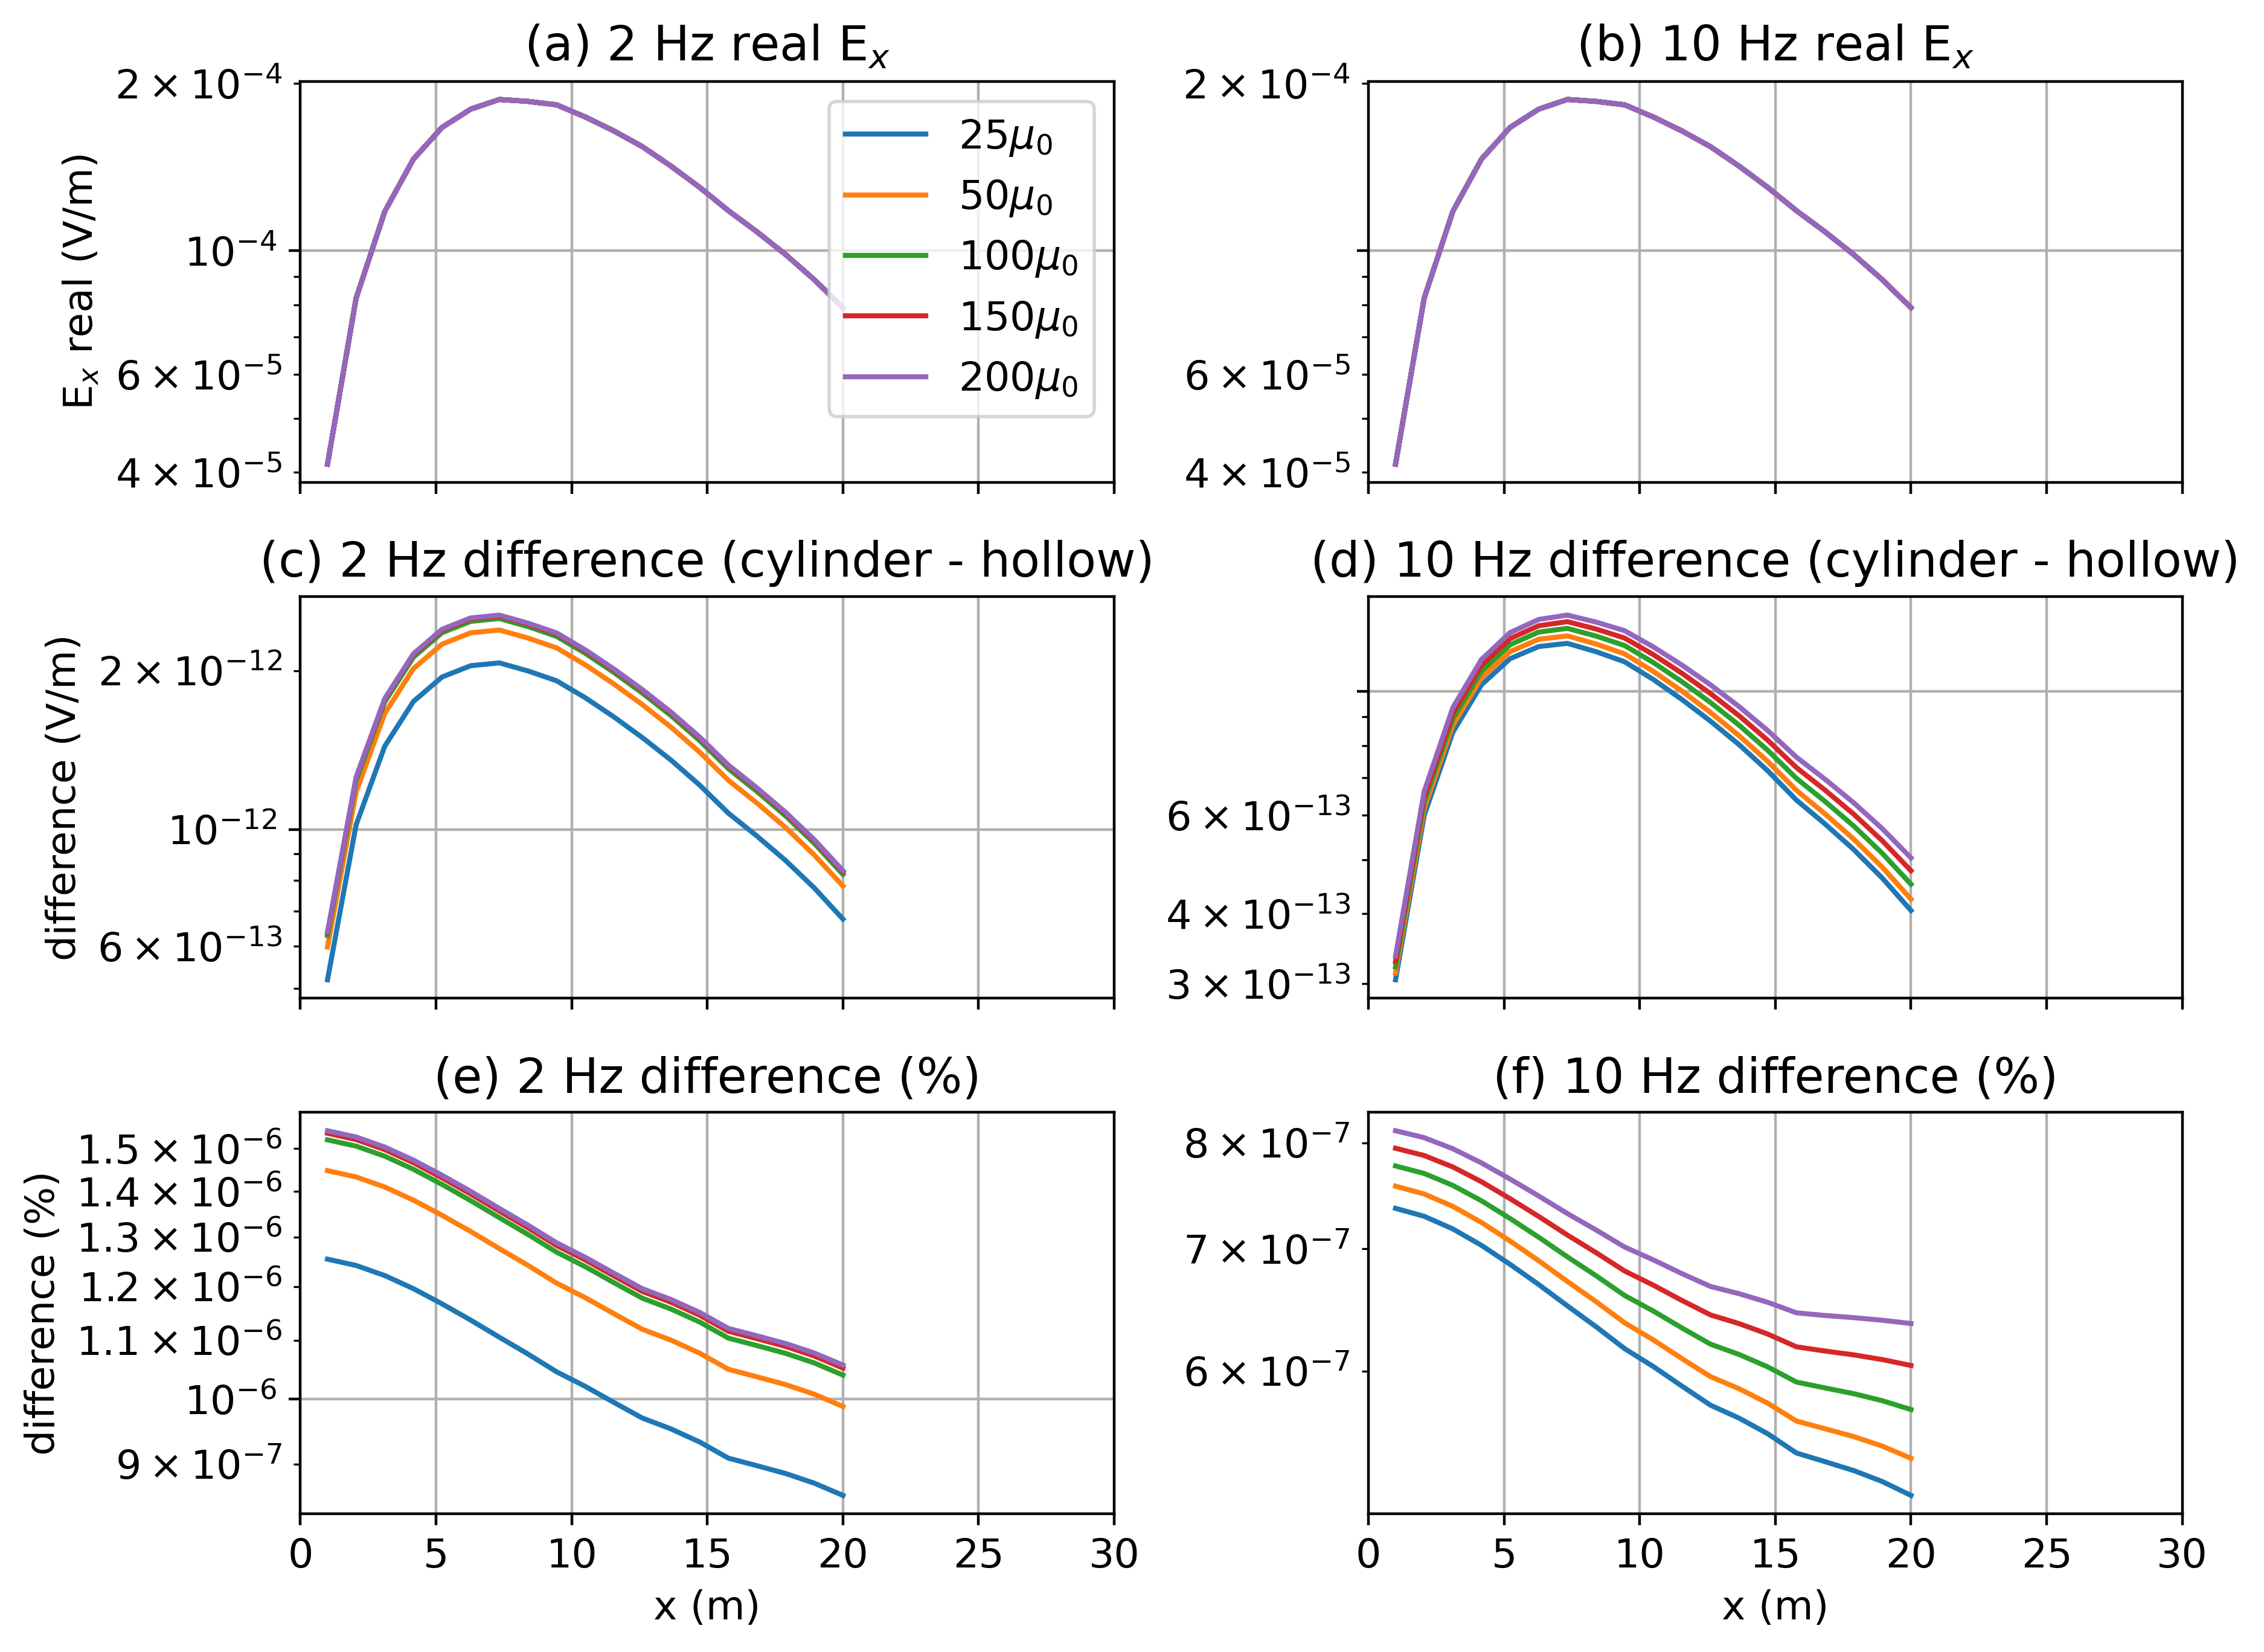

In [51]:
# freqs = frequencies[[7, 12, 14]]
freqs = frequencies[[9, 14]]
fig, ax = plt.subplots(3, len(freqs), figsize=(4.7*len(freqs), 7), sharex=True, dpi=dpi_high)

for j, freq in enumerate(freqs):
    plotind = 0
    for i, key in enumerate(keys): 
        if i in plot_inds:
            if i == 0:
                color = "k"
            else: 
                color = f"C{plotind}"
                plotind = plotind + 1
            dobs = dobs_dict[key][freq]["real_x"][:len(rx_x)]
            d0 = data0[key][freq][:len(rx_x)]
            ax[0, j].semilogy(rx_x, (dobs), color=color, label=f"{mur_casing[i]:1.0f}$\mu_0$")
            ax[0, j].semilogy(rx_x, (d0), f"--{color}")
            ax[1, j].semilogy(rx_x, np.abs(d0-dobs), color)
            ax[2, j].semilogy(rx_x, np.abs(d0-dobs)/np.abs(dobs)*100, color)
    
            # ax[0, j].set_title(f"{freq:1.0f} Hz\n({ascii_lowercase[j]})")
    
            # ax[0, j].set_ylim([2e-7, 5e-6])
            # ax[1, j].set_ylim([3e-10, 1e-6])
            # ax[2, j].set_ylim([5e-2, 1e2])

ax[0, 0].set_xlim([0, 30])
ax[0, 0].set_ylabel("E$_x$ real (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")

ax[0, 0].legend(loc=1)

ax[0, 0].set_title("(a) 2 Hz real E$_x$")
ax[0, 1].set_title("(b) 10 Hz real E$_x$")

ax[1, 0].set_title("(c) 2 Hz difference (cylinder - hollow)")
ax[1, 1].set_title("(d) 10 Hz difference (cylinder - hollow)")

ax[2, 0].set_title("(e) 2 Hz difference (%)")
ax[2, 1].set_title("(f) 10 Hz difference (%)")

for k, a in enumerate(ax.flatten()):
    a.grid()
#     if k > 1: 
#         a.set_title(f"({ascii_lowercase[k]})")

for a in ax[2, :].flatten():
    a.set_xlabel("x (m)")

for a in ax[:, 1:].flatten():
    a.set_yticklabels("")
    

plt.tight_layout()

In [52]:
rx_x[1]

2.0555555555555554

4.166666666666667


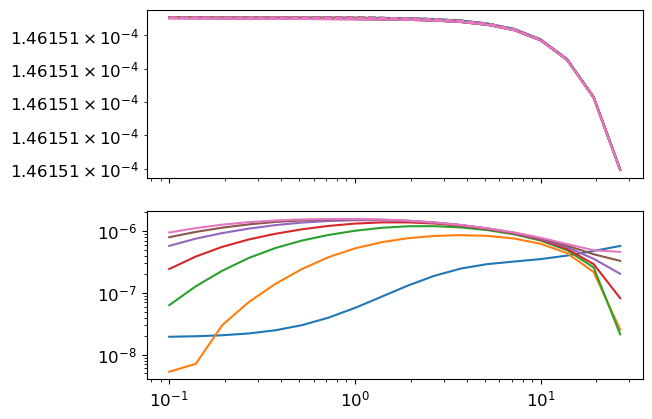

In [53]:
fig, ax = plt.subplots(2, 1, sharex=True)

rx_ind = 3
max_freq_ind = 18
print(rx_x[rx_ind])
for i, key in enumerate(keys): 
    dobs = np.hstack([dobs_dict[key][freq]["real_x"][rx_ind] for freq in frequencies[:max_freq_ind]])
    d0 = np.hstack([data0[key][freq][rx_ind] for freq in frequencies[:max_freq_ind]])
    ax[0].loglog(frequencies[:max_freq_ind], np.abs(dobs), color=f"C{i}", label=key)
    ax[0].loglog(frequencies[:max_freq_ind], np.abs(d0), f"--C{i}")
    # ax[0].loglog(frequencies[:max_freq_ind], np.abs(d0-dobs), f":C{i}")
    ax[1].loglog(frequencies[:max_freq_ind], np.abs(d0-dobs)/np.abs(dobs)*100, f"C{i}")

## look at objective function

In [54]:
def create_misfit(
    key, freq, invert_mu=False, relative_error=None, noise_floor=None,
    true_casing_inds=False, components=["x", "z"]
):
    # create the simulation
    survey = create_survey(freq, components)

    receivers = []
    if "x" in components: 
        receivers.append(["real_x", "imag_x"])
    if "z" in components: 
        receivers.append(["real_z", "imag_z"])
    dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    dobs = data.Data(
        survey=survey, dobs=dobsvec, relative_error=relative_error, noise_floor=noise_floor
    )

    sim = create_simulation(key, survey, invert_mu, true_casing_inds)
    
    dmis = data_misfit.L2DataMisfit(data=dobs, simulation=sim)

    return dmis
    # def dmis_func(x):
    #     f = sim.fields(x)
    #     return np.r_[dmis(x, f=f)], dmis.deriv(x, f=f)

    # return dmis_func  


In [55]:
misfit_dict = {}
relative_error = 0
noise_floor=1e-9

for key in keys:
    if key not in misfit_dict: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = create_misfit(
                    key, freq, invert_mu=True, relative_error=relative_error, noise_floor=noise_floor,
                    components=["x", "z"]
                )
        misfit_dict[key] = tmp

# set up inversions

In [56]:
class SaveInversionProgress(directives.InversionDirective):
    """
    A custom directive to save items of interest during the course of an inversion
    """
    
    results_file = None
    
    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results 
        self.inversion_results = {
            "iteration":[],
            "phi_d":[],
            "dpred":[],
            "logsigma":[],
            "mur":[],
            "residual":[],
            "rms":[],
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append 
        the new values to our dictionary
        """
        
        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        self.inversion_results["logsigma"].append(self.invProb.model[0])
        self.inversion_results["mur"].append(self.invProb.model[1])

        dobs = self.invProb._dmisfit.objfcts[0].data.dobs
        
        self.inversion_results["residual"].append((dobs - self.invProb.dpred))
        self.inversion_results["rms"].append(np.sqrt(np.sum(self.inversion_results["residual"][-1]**2)/len(dobs)))
        
        if self.results_file is not None: 
            with open(f"{self.results_file}", "wb") as fp:
                pickle.dump(self.inversion_results, fp)
        
        

In [57]:
def create_inversion(
    key, freq, invert_mu=False, relative_error=None, noise_floor=None,
    maxIter=20, maxIterCG=50, maxIterLS=20, true_casing_inds=False, components=["x"],
    chifact=0.5
):
    # create the simulation
    survey = create_survey(freq, components)

    receivers = []
    if "x" in components: 
        receivers.append(["real_x", "imag_x"])
    if "z" in components: 
        receivers.append(["real_z", "imag_z"])
    dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    dobs = data.Data(
        survey=survey, dobs=dobsvec, relative_error=relative_error, noise_floor=noise_floor
    )

    sim = create_simulation(key, survey, invert_mu, true_casing_inds)
    dmis = data_misfit.L2DataMisfit(data=dobs, simulation=sim)

    if invert_mu is True: 
        reg = regularization.Smallness(mesh=discretize.TensorMesh([2]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf, 1], upper=np.r_[np.log(100*sigma_casing), np.inf],
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            # aggressive_stepping=True
            # tolF=1e-3, tolX=1e-3,
        )
    
    else: 
        reg = regularization.Smallness(mesh=discretize.TensorMesh([1]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf], 
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            # aggressive_stepping=True
            # tolF=1e-3, tolX=1e-3,
        )

    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=0)

    # directives
    target_misfit = directives.TargetMisfit(chifact=chifact)
    
    if true_casing_inds:
        filename_save = f"inv_{key}_{freq:1.0f}_true_casing.pkl"
    else: 
        filename_save = f"inv_{key}_{freq:1.0f}.pkl"
    inversion_progress = SaveInversionProgress(results_file=f"{directory_path}/{filename_save}")
    
    # inversion 
    inv = inversion.BaseInversion(inv_prob, [target_misfit, inversion_progress])
    
    return inv

# experiment 2: invert for solid cylinder conductivity, permeability 

In [58]:
def create_misfit(
    key, freq, invert_mu=False, relative_error=None, noise_floor=None,
    true_casing_inds=False, components=["x", "z"]
):
    # create the simulation
    survey = create_survey(freq, components)

    receivers = []
    if "x" in components: 
        receivers.append(["real_x", "imag_x"])
    if "z" in components: 
        receivers.append(["real_z", "imag_z"])
    dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    dobs = data.Data(
        survey=survey, dobs=dobsvec, relative_error=relative_error, noise_floor=noise_floor
    )

    sim = create_simulation(key, survey, invert_mu, true_casing_inds)
    
    dmis = data_misfit.L2DataMisfit(data=dobs, simulation=sim)

    return dmis
    # def dmis_func(x):
    #     f = sim.fields(x)
    #     return np.r_[dmis(x, f=f)], dmis.deriv(x, f=f)

    # return dmis_func  


In [59]:
misfit_dict = {}
relative_error = 0
noise_floor=1e-9

for key in keys:
    if key not in misfit_dict: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = create_misfit(
                    key, freq, invert_mu=True, relative_error=relative_error, noise_floor=noise_floor,
                    components=["x", "z"]
                )
        misfit_dict[key] = tmp

In [60]:
np.log(sigma_casing)

15.424948470398375

In [61]:
logsigmas = np.linspace(12, 18, 50)
rel_permeabilities = np.linspace(1, 250, 50)

tmpsig = np.kron(logsigmas, np.ones_like(rel_permeabilities))
tmpmu = np.kron(np.ones_like(logsigmas), rel_permeabilities)

model_matrix = np.c_[tmpsig, tmpmu]
freqs = frequencies[::7]
# tmp

In [62]:
freqs

array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])

In [63]:
%%time
objfctvals = {}

objfct_keys = [keys[4]]
for key in objfct_keys:
    objfctvals_tmp = {}
    t0 = time.time()
    for freq in freqs:  
        
        phi = misfit_dict[key][freq]
        objfctvals_tmp[freq]  = np.hstack([phi(model_matrix[i, :]) for i in range(model_matrix.shape[0])])
    print(f"{key} {freq:1.1e} Hz: {time.time() - t0:1.2f} s")
    objfctvals[key] = objfctvals_tmp


casing_sig5e+06_mur100 1.0e+04 Hz: 427.35 s
CPU times: user 1h 48min 17s, sys: 5min 39s, total: 1h 53min 57s
Wall time: 7min 7s


Text(0.5, 0, 'permeability')

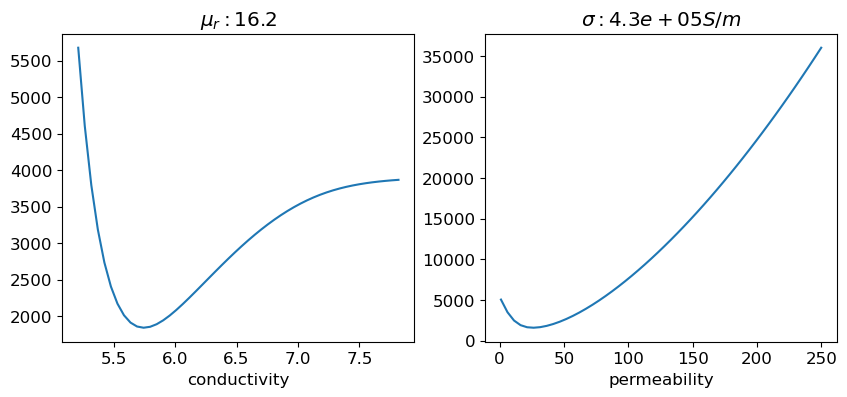

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

key = keys[4]
freq = freqs[1]
plotme = objfctvals[key][freq].reshape(len(logsigmas), len(rel_permeabilities))

sig_ind = 8
mur_ind = 3

ax[0].set_title(f"$\mu_r: {rel_permeabilities[mur_ind]:1.1f}$")
ax[1].set_title(f"$\sigma: {np.exp(logsigmas[sig_ind]):1.1e} S/m$")

ax[0].plot(np.log10(np.exp(logsigmas)), plotme[:, mur_ind])
ax[1].plot(rel_permeabilities, plotme[sig_ind, :])

ax[0].set_xlabel("conductivity")
ax[1].set_xlabel("permeability")

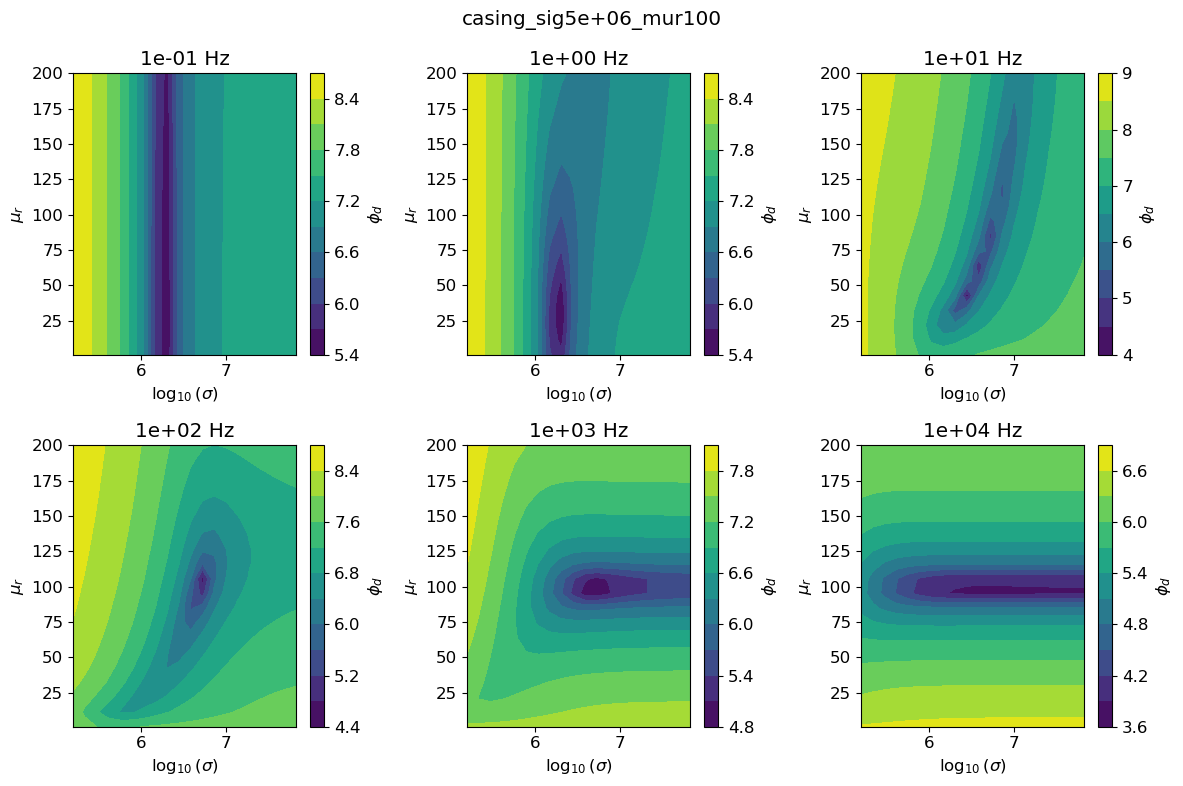

In [168]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
key = keys[4]

ax = ax.flatten()
for i, freq in enumerate(freqs): 
    plotme = objfctvals[key][freq].reshape(len(logsigmas), len(rel_permeabilities))
    
    cb = plt.colorbar(
        ax[i].contourf(np.log10(np.exp(logsigmas)), rel_permeabilities, np.log10(plotme.T), 10), 
        ax=ax[i]
    )
    cb.set_label("$\phi_d$")

    ax[i].set_title(f"{freq:1.0e} Hz")
    ax[i].set_xlabel("$\log_{10}(\sigma)$")
    ax[i].set_ylabel("$\mu_r$")

fig.suptitle(f"{key}")
plt.tight_layout()

In [82]:
sigdc

1800000.0000000005

In [179]:
inv_dict = {}
relative_error = 0.0
noise_floor = 1e-9

for i, key in enumerate(keys):
    # if i == 0: 
    #     chifact = 0.5
    # else: 
    chifact = 0.00001
    if key not in inv_dict: 
        tmp = {}
        for freq in frequencies:
            
            tmp[freq] = create_inversion(
                    key, freq, invert_mu=True, relative_error=relative_error, noise_floor=noise_floor,
                    components=["x", "z"], chifact=chifact
                )
        inv_dict[key] = tmp

In [183]:
tmp = inv_dict[keys[0]][frequencies[0]]
np.unique(tmp.invProb.dmisfit.objfcts[0].simulation.muMap * np.r_[10, 1])

array([1.25663706e-06])

In [184]:
t = casing_t
sigdc = sigma_casing * (1-(casing_b-t)**2/casing_b**2)
# starting_models = {
#     True: np.r_[np.log(sigstart), 1],
#     False: np.r_[np.log(sigstart)]
# }

In [185]:
keys

['casing_sig5e+06_mur1',
 'casing_sig5e+06_mur10',
 'casing_sig5e+06_mur25',
 'casing_sig5e+06_mur50',
 'casing_sig5e+06_mur100',
 'casing_sig5e+06_mur150',
 'casing_sig5e+06_mur200']

In [309]:
mrec_dict = {}

for i, key in enumerate(keys):
    if key not in mrec_dict: 
        tmp = {}
        for j, freq in enumerate(frequencies):
            print(f"\n\n------------------------ {key} : {freq} Hz -------------------------- \n")
            # if i == 0: 
            mstart = np.r_[np.log(sigdc), mur_casing[i]]
            # else: 
            #     mstart = mrec_dict[keys[0]][freq]
            tmp[freq] = inv_dict[key][freq].run(mstart)
            print(f"recovered conductivity: {np.exp(inv_dict[key][freq].m[0]):1.2e}, recovered permeability: {inv_dict[key][freq].m[1]:1.2f} mu0 \n")
        mrec_dict[key] = tmp



------------------------ casing_sig5e+06_mur1 : 0.1 Hz -------------------------- 


                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DMagneticField problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  3.22e+02  0.00e+00  3.22e+02    5.59e+04      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.2250e+01
1 : |xc-x_last| = 1.3702e-03 <= tolX*(1+|x0|) = 1.5438e+00
0 : |proj(x-g)-x|    = 5.5861e+04 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 5.5861e+04 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <=

In [310]:
inv_results = {}

for key in keys:
    if key not in inv_results: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = inv_dict[key][freq].directiveList.dList[1].inversion_results
        inv_results[key] = tmp

In [311]:
tmp = inv_results[keys[0]][frequencies[0]]

In [312]:
tmp = inv_dict[keys[0]][frequencies[0]]

In [313]:
phi_d_final = {}
chifact_final = {}
phid_star = len(rx_x)*len(rx_z)*2

for key in keys:
    phid_tmp = np.ones(len(frequencies)) * np.nan
    for i, freq in enumerate(frequencies): 
        phid = inv_results[key][freq]["phi_d"]
        if len(phid) > 0: 
            phid_tmp[i] = phid[-1]
    phi_d_final[key] = phid_tmp
    chifact_final[key] = phi_d_final[key] / phid_star

In [314]:
phid_min = {}
chifact_min = {}
logsig_min = {}
mur_min = {}
rms_min = {}

for key in keys:
    phid_tmp = np.ones(len(frequencies)) * np.nan
    logsig_tmp = np.ones(len(frequencies)) * np.nan
    mur_tmp = np.ones(len(frequencies)) * np.nan
    rms_tmp = np.ones(len(frequencies)) * np.nan
    for i, freq in enumerate(frequencies): 
        phid = inv_results[key][freq]["phi_d"]
        if len(phid) > 0: 
            ind_min = np.argmin(phid)
            phid_tmp[i] = phid[ind_min]
            logsig_tmp[i] = inv_results[key][freq]["logsigma"][ind_min]
            mur_tmp[i] = inv_results[key][freq]["mur"][ind_min]
            rms_tmp[i] = inv_results[key][freq]["rms"][ind_min]
    phid_min[key] = phid_tmp
    logsig_min[key] = logsig_tmp
    mur_min[key] = mur_tmp
    rms_min[key] = rms_tmp

In [315]:
# fig, ax = plt.subplots(3, 1, figsize=(6, 12), sharex=True) 

# for key in keys: 
#     mrec = np.vstack(mrec_dict[key].values())
    
#     ax[0].semilogx(frequencies, phi_d_final[key] / phid_star, "o", label=key)
#     ax[0].semilogx(frequencies,  np.ones_like(frequencies),"--k")
#     ax[1].loglog(frequencies, np.exp(mrec[:, 0]), "o", label=key)
#     ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
#     ax[1].loglog(frequencies, np.ones_like(frequencies)*sigdc, "--k")
#     ax[2].semilogx(frequencies, mrec[:, 1], "o", label=key)

# ax[1].set_ylim([1e6, 1e8])
# # ax[0].legend()

In [316]:
# fig, ax = plt.subplots(3, 1, figsize=(6, 12), sharex=True) 

# for key in keys: 
#     ax[0].loglog(frequencies, phid_min[key], "o", label=key)
#     ax[0].semilogx(frequencies, phid_star * np.ones_like(frequencies),"--k")
#     ax[1].loglog(frequencies, np.exp(logsig_min[key]), "o", label=key)
#     ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
#     ax[1].loglog(frequencies, np.ones_like(frequencies)*sigdc, "--k")
#     ax[2].semilogx(frequencies, (mur_min[key]), "o", label=key)
# ax[0].legend()

In [317]:
markers = ["o", "v", "s", "D", "p", "^", "h"]

In [318]:
mur_casing

array([  1,  10,  25,  50, 100, 150, 200])

In [319]:
plotkeys = np.hstack([keys[0], keys[2:]])
plotkeys

array(['casing_sig5e+06_mur1', 'casing_sig5e+06_mur25',
       'casing_sig5e+06_mur50', 'casing_sig5e+06_mur100',
       'casing_sig5e+06_mur150', 'casing_sig5e+06_mur200'], dtype='<U22')

In [320]:
def mur_by_skindepth(delta):
    omega = 2 * np.pi * frequencies
    return 2 / (omega * delta**2 * sigma_casing) / mu_0

In [321]:
mur_by_skindepth(casing_t)/mu_0

array([4.03144180e+09, 2.90137090e+09, 2.08807507e+09, 1.50275771e+09,
       1.08151320e+09, 7.78349553e+08, 5.60167022e+08, 4.03144180e+08,
       2.90137090e+08, 2.08807507e+08, 1.50275771e+08, 1.08151320e+08,
       7.78349553e+07, 5.60167022e+07, 4.03144180e+07, 2.90137090e+07,
       2.08807507e+07, 1.50275771e+07, 1.08151320e+07, 7.78349553e+06,
       5.60167022e+06, 4.03144180e+06, 2.90137090e+06, 2.08807507e+06,
       1.50275771e+06, 1.08151320e+06, 7.78349553e+05, 5.60167022e+05,
       4.03144180e+05, 2.90137090e+05, 2.08807507e+05, 1.50275771e+05,
       1.08151320e+05, 7.78349553e+04, 5.60167022e+04, 4.03144180e+04])

/tmp/ipykernel_3045365/946283219.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  plt.plot(np.vstack(mrec_dict[keys[0]].values())[:, 0])


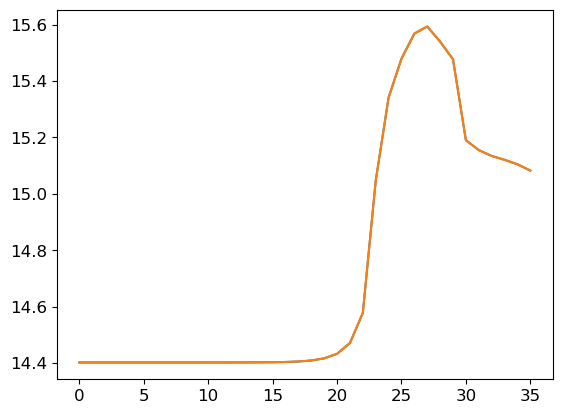

In [322]:
plt.plot(np.vstack(mrec_dict[keys[0]].values())[:, 0])
plt.plot(logsig_min[keys[0]])


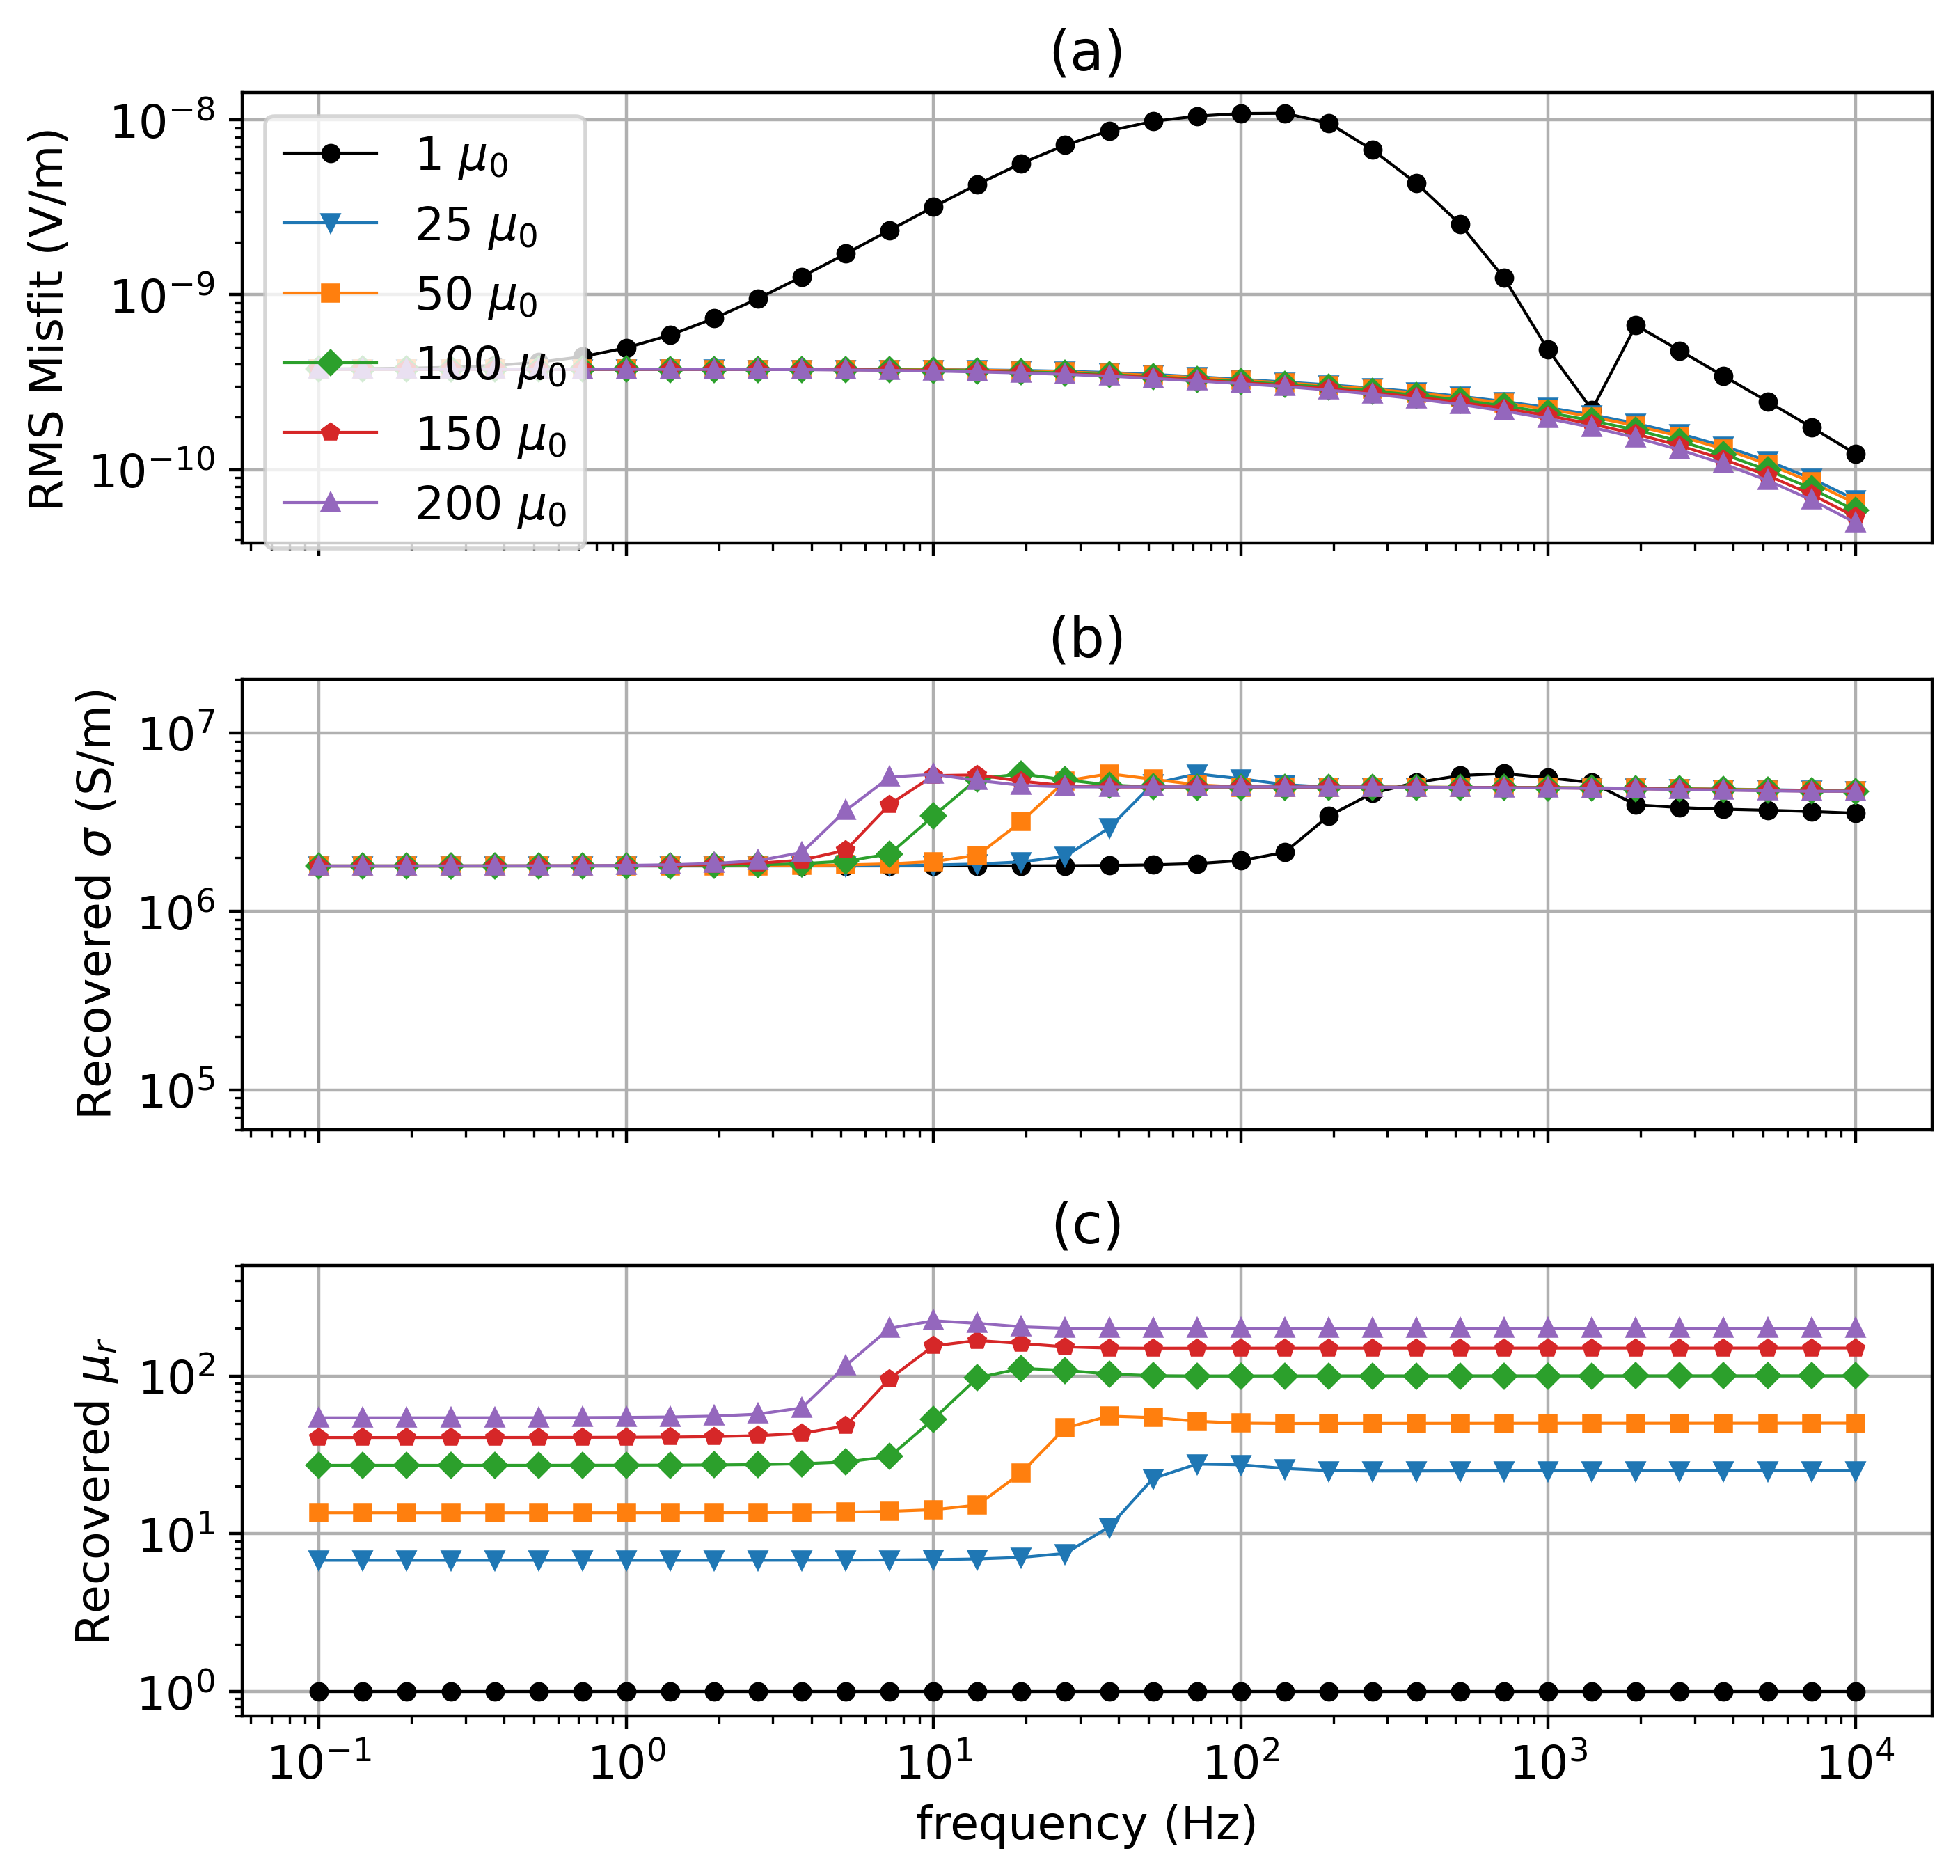

In [323]:
fig, ax = plt.subplots(3, 1, figsize=(7.2, 6.9), sharex=True, dpi=dpi_high) 

for i, key in enumerate(plotkeys): 
    color = "k" if i==0 else f"C{i-1}"
    label = f"{key.split('_')[-1][3:]} $\mu_0$"
    ax[0].loglog(frequencies, rms_min[key], f"-{markers[i]}", color=color, lw=0.75, ms=4, label=label)
    # ax[0].semilogx(frequencies, phid_star * np.ones_like(frequencies),"--k")
    ax[1].loglog(frequencies, np.exp(logsig_min[key]), f"-{markers[i]}", color=color, lw=0.75, ms=4, label=label)
    # ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
    # ax[1].loglog(frequencies, np.ones_like(frequencies)*sigdc, "--k")
    ax[2].loglog(frequencies, (mur_min[key]), f"-{markers[i]}", color=color, lw=0.75, ms=4, label=label)
    
for a in ax:
    a.grid()
    
ax[0].legend(loc=2)
ax[1].set_ylim(6e4, 2e7)
ax[2].set_ylim([0.7, 500])

# ax[2].text(1.1e3, 2, "$\delta\sim t/2$", alpha=0.7)
# ax[2].loglog(frequencies, mur_by_skindepth(casing_t/2), ":k", alpha=0.6)

# ax[2].text(2e1, 2, "$\delta\sim 1.3 t$", alpha=0.7)
# ax[2].loglog(frequencies, mur_by_skindepth(1.3*casing_t), ":k", alpha=0.6)

ax[0].set_ylabel("RMS Misfit (V/m)")
ax[1].set_ylabel("Recovered $\sigma$ (S/m)")
ax[2].set_ylabel("Recovered $\mu_r$")
ax[2].set_xlabel("frequency (Hz)")

ax[0].set_title("(a)")
ax[1].set_title("(b)")
ax[2].set_title("(c)")

plt.tight_layout()

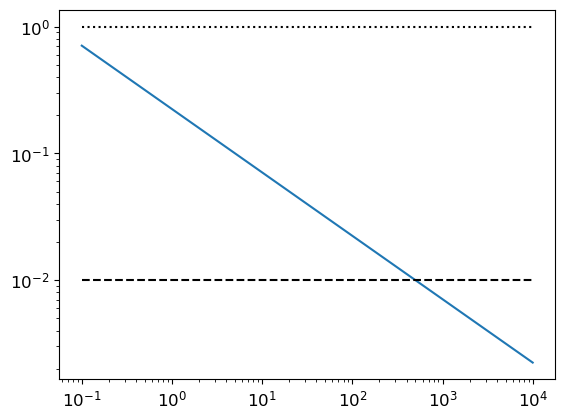

In [200]:
skin_depths_casing = 500/np.sqrt(sigma_casing * frequencies) 

fig, ax = plt.subplots(1, 1) 
ax.loglog(frequencies, skin_depths_casing)
ax.loglog(frequencies, np.ones_like(frequencies)*casing_t, "--k")
ax.loglog(frequencies, np.ones_like(frequencies)*csz, ":k")

In [201]:
from scipy import stats

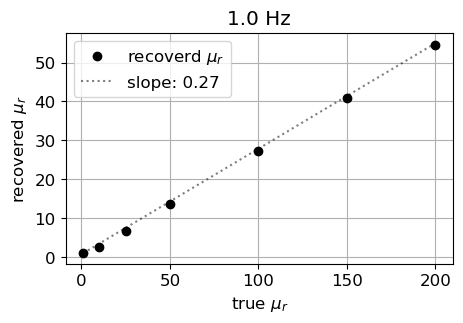

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

freq_ind = 7

mur_1Hz =  np.array([mur_min[k][freq_ind] for k in plot_keys])
mur_true = np.array([np.float64(k.split('_')[-1][3:]) for k in plot_keys])

slope, intercept, r, p, std_err = stats.linregress(mur_true-1, mur_1Hz-1)

ax.plot(mur_true, mur_1Hz, "ko", label="recoverd $\mu_r$")
    
ax.plot(mur_true, slope*(mur_true-1)+1, ":k", alpha=0.5, label=f"slope: {slope:1.2f}")
ax.set_xlabel("true $\mu_r$")
ax.set_ylabel("recovered $\mu_r$")
ax.set_title(f"{frequencies[freq_ind]} Hz")
ax.grid("both")
# ax.set_aspect(1)
ax.legend()
    # ax.plot()

In [203]:
(slope * casing_b / casing_t)

1.3561714034354575

NameError: name 'mrec_min' is not defined

In [215]:
fields_rec = {}

for key in keys:
    tmp_fields = {}
    for i, freq in enumerate(frequencies):
        tmp_fields[freq] = inv_dict[key][freq].invProb.dmisfit.objfcts[0].simulation.fields(np.r_[logsig_min[key][i], mur_min[key][i]])
 
    fields_rec[key] = tmp_fields

In [218]:
def plot_fields(
    field_plot, freq_ind=0, xlim=500*np.r_[-1, 1], zlim=np.r_[-1000, 10], component="real", ax=None, vmin=None, vmax=None, aspect=True,
    plot_source=False
):
    if ax is None: 
        fig, ax = plt.subplots(1,1)

    field_plot = mesh.average_face_to_cell_vector * np.squeeze(field_plot)
    
    out = mesh.plot_image(
        getattr(field_plot, component), "CCv", view="vec", 
        range_x = xlim, range_y = zlim,
        sample_grid = np.r_[np.diff(xlim)/100, np.diff(zlim)/100],
        mirror=True, #mirror_data=field_mirror,
        ax=ax, 
        pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)},
        stream_threshold=vmin
    )

    if plot_source is True: 
        ax.plot(src_locations[:, 0], src_locations[:, 2], "w", lw=2)
    
    cb = plt.colorbar(out[0], ax=ax)
    # cb.set_label("Electric Field (V/m)")
    if aspect is True:
        ax.set_aspect(1)

    return out, cb

0.15351436386215794

In [258]:
x_data = mesh.nodes_x[31]
data_locs = np.hstack([mesh.faces_x[:, 0] == x_data, np.zeros(mesh.n_faces_z, dtype=bool)])
np.sum(data_locs)

581

In [279]:
keys

['casing_sig5e+06_mur1',
 'casing_sig5e+06_mur10',
 'casing_sig5e+06_mur25',
 'casing_sig5e+06_mur50',
 'casing_sig5e+06_mur100',
 'casing_sig5e+06_mur150',
 'casing_sig5e+06_mur200']

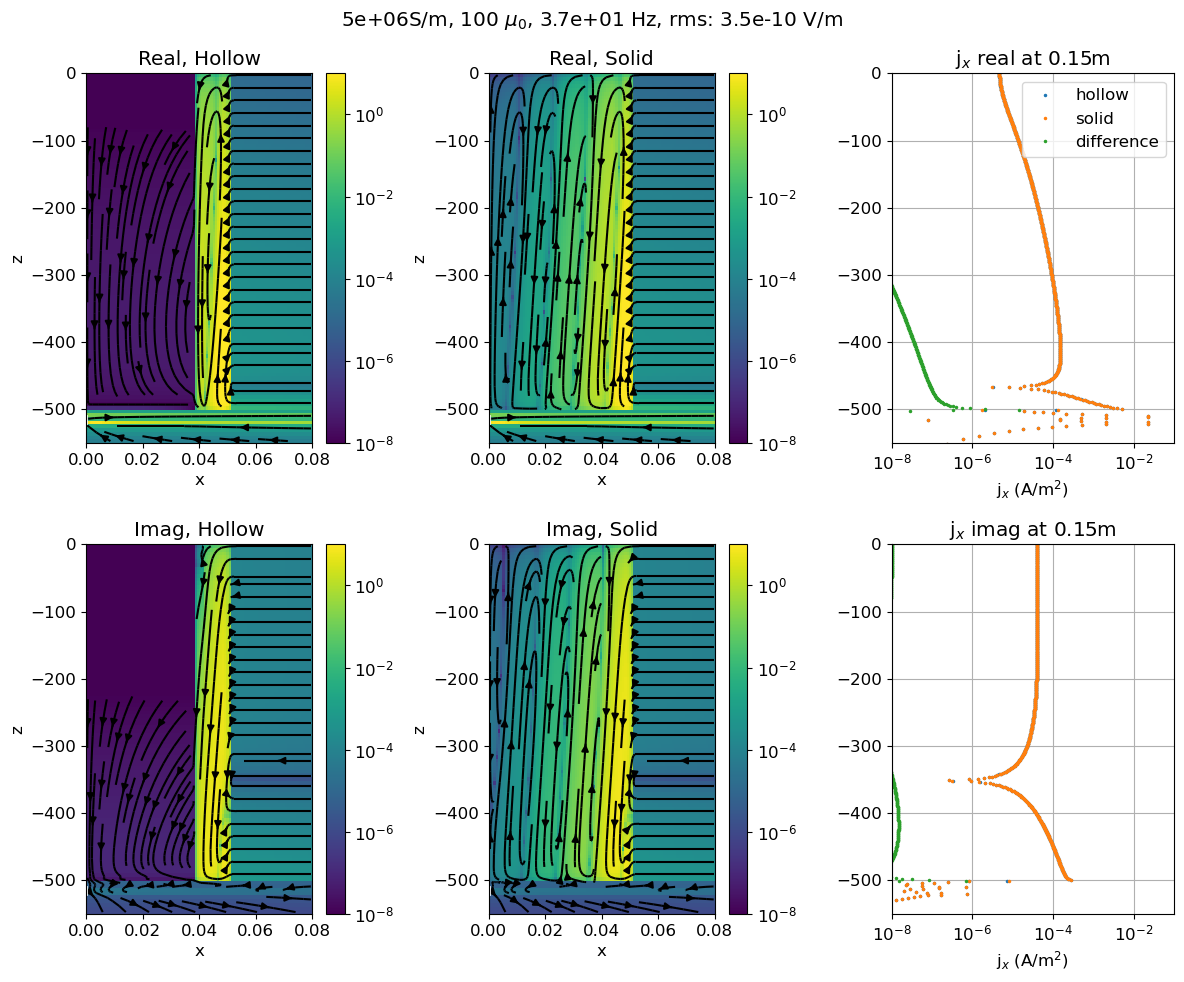

In [307]:
fig, ax = plt.subplots(2, 3, figsize=(12, 10))

key = keys[4]
freq_ind = 18

aspect = False
xlim = 0.08*np.r_[0, 1]
zlim = np.r_[-550, 0] 
plot_source = True
vmin=1e-8
vmax=1e1

true_fields = fields[key]
fields_true = true_fields[true_fields.simulation.survey.source_list[freq_ind], "j"]
plot_fields(fields_true, component="real", ax=ax[0, 0], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
plot_fields(fields_true, component="imag", ax=ax[1, 0], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
ax[0, 0].set_title("Real, Hollow")
ax[1, 0].set_title("Imag, Hollow")


fields_pred = fields_rec[key][frequencies[freq_ind]][:, "j"]
plot_fields(fields_pred, component="real", ax=ax[0, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
plot_fields(fields_pred, component="imag", ax=ax[1, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
ax[0, 1].set_title("Real, Solid")
ax[1, 1].set_title("Imag, Solid")

for i, component in enumerate(["real", "imag"]):
    ax[i, 2].semilogx(np.abs(getattr(fields_true[data_locs], component)), mesh.cell_centers_z, ".", ms=3, label="hollow")
    ax[i, 2].semilogx(np.abs(getattr(fields_pred[data_locs], component)), mesh.cell_centers_z, ".", ms=3, label="solid")
    ax[i, 2].semilogx(np.abs(getattr(fields_pred[data_locs] - fields_true[data_locs], component)), mesh.cell_centers_z, ".", ms=3, label="difference")
    ax[i, 2].set_ylim(zlim)
    ax[i, 2].set_xlim(np.r_[vmin, vmax*1e-2])
    ax[i, 2].grid()
    ax[i, 2].set_title(f"j$_x$ {component} at {x_data:1.2f}m")
    ax[i, 2].set_xlabel("j$_x$ (A/m$^2$)")

ax[0, 2].legend(loc=1)
fig.suptitle(f"{key.split('_')[1][3:]}S/m, {key.split('_')[-1][3:]} $\mu_0$, {frequencies[freq_ind]:1.1e} Hz, rms: {rms_min[key][freq_ind]:1.1e} V/m")

# fields_diff = fields_true - fields_pred
# plot_fields(fields_diff, component="real", ax=ax[0, 1], vmin=vmin, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# plot_fields(fields_diff, component="imag", ax=ax[1, 1], vmin=vmin, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)


plt.tight_layout()

In [82]:
std_err

0.001591052547054751